In [1]:
from util import output_embedding,get_kitty_data_dir
from sklearn.preprocessing import LabelEncoder
from skimage import io
import mxnet as mx
import numpy as np
import time
import densecrf as dcrf
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def output_matchingscore(left_dir,right_dir,dis_range,ctx):
    left,right,left_pred,right_pred = output_embedding(left_dir,right_dir,308)
    ms = np.zeros((left_pred.shape[1],left_pred.shape[2],dis_range))
    
    for y in range(left_pred.shape[1]):
        left_embedding = mx.nd.array(left_pred[:,y].T,ctx)
        right_embedding = mx.nd.array(right_pred[:,y],ctx)
        tmp = mx.nd.dot(left_embedding,right_embedding).asnumpy()
        
        for x in range(left_pred.shape[2]):
            if x - (dis_range-1) <0:
                t = 0
            else:
                t = x - dis_range + 1 
            length = len(tmp[x,t:x+1])
            ms[y,x,:length] = tmp[x,t:x+1][::-1]
    return ms,left,right

def generate_ms():
    img_dir = get_kitty_data_dir(0,50)
    dis_range = 50
    ctx = mx.gpu(3)

    for num,img in enumerate(img_dir):
        begin = time.time()
        ms ,left,right = output_matchingscore(img[1],img[2],dis_range,ctx)
        np.save('./matching_score/%d' % num,ms)

def compute_unary(labels, M, GT_PROB=0.5):
    """
    Simple classifier that is 50% certain that the annotation is correct
    (same as in the inference example).
    """
    u_energy = -np.log(1.0 / M)
    n_energy = -np.log((1.0 - GT_PROB) / (M - 1))
    p_energy = -np.log(GT_PROB)

    U = np.zeros((M, len(labels)), dtype='float32')
    U[:, labels > 0] = n_energy
    U[labels, np.arange(U.shape[1])] = p_energy
    U[:, labels == 0] = u_energy
    return U
#generate_ms()

In [47]:
scale = 6
img_dir = get_kitty_data_dir(9,10)
data = [] ; label = []
for num,img in enumerate(img_dir):
    dis ,left,right = img
    dis = np.round(io.imread(dis)/256.0).astype(int)
    left = io.imread(left)[scale:dis.shape[0]-scale,scale:dis.shape[1]-scale]
    right = io.imread(right)[scale:dis.shape[0]-scale,scale:dis.shape[1]-scale]
    dis = dis[scale:dis.shape[0]-scale,scale:dis.shape[1]-scale]
    ms = np.load('./matching_score/%d.npy' % 9)
    dis = np.where(dis>49,49,dis)

In [39]:
print dis.shape,ms.shape,left.shape

(358, 1214) (358, 1214, 50) (358, 1214, 3)


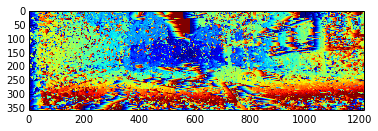

In [41]:
class_num = 50
d = dcrf.DenseCRF2D(dis.shape[1],dis.shape[0],class_num)
tmp = ms.argmax(axis=2)
u = compute_unary(tmp.ravel(),class_num,0.9)

d.setUnaryEnergy(u)

left = np.ascontiguousarray(left)
d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)

# This adds the color-dependent term, i.e. features are (x,y,r,g,b).
d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=left,
                       compat=10,
                       kernel=dcrf.DIAG_KERNEL,
                       normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = d.inference(5)
dis_map = np.argmax(Q, axis=0).reshape(dis.shape[:2])

res = dis_map.astype('float32') * 255 / dis_map.max()
plt.imshow(res)
plt.show()

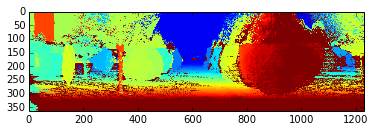

In [48]:
class_num = 50
d = dcrf.DenseCRF2D(dis.shape[1],dis.shape[0],class_num)
tmp = ms.argmax(axis=2)
u = compute_unary(dis.ravel(),class_num,0.1)
d.setUnaryEnergy(u)

left = np.ascontiguousarray(left)
d.addPairwiseGaussian(sxy=3, compat=3)
d.addPairwiseBilateral(sxy=100, srgb=13, rgbim=left, compat=10)
Q = d.inference(4)
dis_map = np.argmax(Q, axis=0).reshape(dis.shape[:2])

res = dis_map.astype('float32') * 255 / dis_map.max()
plt.imshow(res)
plt.show()

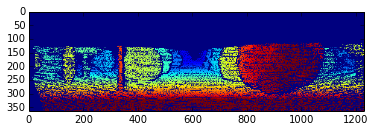

In [49]:
plt.imshow(dis.astype('float32')*255/dis.max())